In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
from functools import partial
from copy import deepcopy
from toolz import compose, valmap, keyfilter, identity
from itertools import combinations, product
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

import sbi
import sbi.utils
import sbi.inference
import sbi.analysis
import sbibm

import swyft
import swyft.utils.constrainedcorner as cc

import tmnre
import tmnre.metrics
import tmnre.benchmark
import tmnre.coverage.oned
from tmnre.nn.resnet import make_resenet_tail
from tmnre.marginalize import filter_marginals_by_dim

In [3]:
def get_rotation_matrix(d: int) -> np.ndarray:
    # We aim to rotate x to y
    x = np.ones((d, 1))
    y = np.zeros((d, 1))
    y[-1, :] = 1.0

    # Create orthonormal basis for the planar subspace
    u = x / np.linalg.norm(x)
    v = y - np.dot(u.T, y) * u
    v /= np.linalg.norm(v)

    # Create rotation matrix within planar subspace
    cos_theta = np.dot(x.T, y).flatten() / (np.linalg.norm(x) * np.linalg.norm(y))
    sin_theta = np.sqrt(1 - cos_theta ** 2)
    R_theta = np.array([[cos_theta, -sin_theta], [sin_theta, cos_theta]]).squeeze()
    uv = np.concatenate([u, v], axis=-1)

    # Assemble total rotation (I - uu' - vv') + ([u, v] R [u, v].T) == Project onto complement + project onto rotated planar subspace
    return np.eye(d) - np.dot(u, u.T) - np.dot(v, v.T) + uv @ R_theta @ uv.T

def get_new_uniform_bounds(q, d):
    box_corners = np.asarray(list(product([0.0, 1.0], repeat=d))).T
    upper_bounds = (q @ box_corners).max(axis=1).tolist()
    lower_bounds = (q @ box_corners).min(axis=1).tolist()
    bounds = list(zip(lower_bounds, upper_bounds))
    return bounds

Q = get_rotation_matrix(10)
Qt = torch.from_numpy(Q).float()
new_bounds = get_new_uniform_bounds(Q, 10)

In [11]:
keepdim = 4
indstokeep = list(combinations(range(keepdim), 2)) + [(i,) for i in range(keepdim)]
keep = lambda x: x in indstokeep

labels = [r"$\theta_{" + str(i) + "}$" for i in range(keepdim)]

rot_truth = Q @ (0.25 * np.ones(10))

kwargs = dict(
#     kde=True,
    kde=False,
    bins=50,
    figsize=(2.5, 2.5),
    truth=rot_truth,
    xlim=new_bounds[0],        # THESE ARE DIFFERENT FOR LAST DIM
    ylim_lower=new_bounds[0],  # THESE ARE DIFFERENT FOR LAST DIM
    labels=labels,
    ticklabels=False,
    ticklabelsize="small",
)

fittext_kwargs = dict(
    y=0.8,
    fontsize="x-large",
)

save_kwargs = dict(
    bbox_inches='tight',
    dpi=300,
    facecolor="white",
    transparent=False,
)

In [12]:
# double check we did the rotation correctly.
TASK_NAME = "eggbox"
NUM_OBS = 1
DIM = 10

task = sbibm.get_task(
    TASK_NAME,
    dim=DIM,
)

theta0 = task.get_true_parameters(NUM_OBS).squeeze()
sim = compose(task.g, lambda x: Qt.t() @ x)
sim(Qt @ theta0)

tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])

## Reference

In [13]:
path = f"eggbox-{10}-ref.pickle"
with open(path, "rb") as f:
    _, ref_samples = pickle.load(f)

rot_ref_samples = np.dot(ref_samples, Q.T)
rot_ref_marginals = tmnre.marginalize.all_marginals(rot_ref_samples)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 37.48it/s]


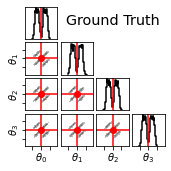

In [14]:
dfs = swyft.utils.get_df_dict_from_marginals(rot_ref_marginals)
dfs = keyfilter(keep, dfs)

fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="Ground Truth",
    x=0.35,
    **fittext_kwargs,
)
# fig.savefig("figures/eggbox-ref-corner.png", **save_kwargs)

# swyft

In [17]:
path = f"rot-swyft-samples.pickle"
with open(path, "rb") as f:
    rot_swyft = pickle.load(f)
rot_swyft.keys()

dict_keys(['swyft/nsims-1000', 'swyft/nsims-10000', 'swyft/nsims-100000', 'rej-swyft/nsims-1000', 'rej-swyft/nsims-10000', 'rej-swyft/nsims-100000'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 29.21it/s]


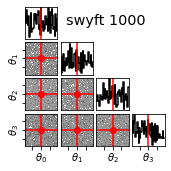

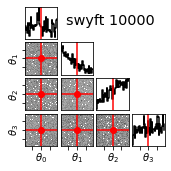

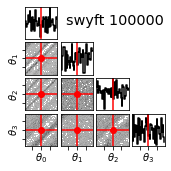

In [29]:
relkeys = filter(lambda x: "rej-swyft" in x, rot_swyft.keys())
for k in relkeys:
    n = int(k.split("-")[-1])
    rot_swy_s = rot_swyft[k]
    dfs = swyft.utils.get_df_dict_from_marginals(rot_swy_s)
    dfs = keyfilter(keep, dfs)

    fig, axes = cc.corner(
        dfs,
        **kwargs,
    )
    plt.figtext(
        s=f"swyft {n}",
        x=0.35,
        **fittext_kwargs,
    )
# fig.savefig("figures/eggbox-ref-corner.png", **save_kwargs)

# Below is all old stuff

In [4]:
path = f"rot-swyft-samples.pickle"
with open(path, "rb") as f:
    rot_swyft = pickle.load(f)
rot_swyft.keys()

dict_keys(['swyft/nsims-1000', 'swyft/nsims-10000', 'swyft/nsims-100000', 'rej-swyft/nsims-1000', 'rej-swyft/nsims-10000', 'rej-swyft/nsims-100000'])

In [3]:
path = f"eggbox-{10:02d}-samples.pickle"
with open(path, "rb") as f:
    gen_eggbox = pickle.load(f)
gen_eggbox.keys()

dict_keys(['sbi/nsims-1000', 'sbi/nsims-10000', 'sbi/nsims-100000', 'swyft/nsims-1000', 'swyft/nsims-10000', 'swyft/nsims-100000', 'rej-swyft/nsims-1000', 'rej-swyft/nsims-10000', 'rej-swyft/nsims-100000', 'seq/nsims-1000', 'seq/nsims-10000'])

In [4]:
path = f"eggbox-seq-marg-{2:02d}-marginals.pickle"
with open(path, "rb") as f:
    seq_eggbox = pickle.load(f)
seq_eggbox.keys()

dict_keys([(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 6), (5, 7), (5, 8), (5, 9), (6, 7), (6, 8), (6, 9), (7, 8), (7, 9), (8, 9)])

In [5]:
path = f"eggbox-{10}-ref.pickle"
with open(path, "rb") as f:
    ref_marginals, ref_samples = pickle.load(f)

In [6]:
keepdim = 4
indstokeep = list(combinations(range(keepdim), 2)) + [(i,) for i in range(keepdim)]
keep = lambda x: x in indstokeep

labels = [r"$\theta_{" + str(i) + "}$" for i in range(keepdim)]

In [7]:
kwargs = dict(
#     kde=True,
    kde=False,
    bins=50,
    figsize=(2.5, 2.5),
    truth=0.25 * np.ones(10),
    xlim=(0., 1.),
    ylim_lower=(0., 1.),
    labels=labels,
    ticklabels=False,
    ticklabelsize="small",
)

fittext_kwargs = dict(
    y=0.8,
    fontsize="x-large",
)

save_kwargs = dict(
    bbox_inches='tight',
    dpi=300,
    facecolor="white",
    transparent=False,
)

100%|██████████| 6/6 [00:00<00:00, 55.54it/s]


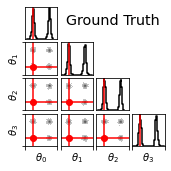

In [8]:
dfs = swyft.utils.get_df_dict_from_marginals(ref_marginals)
dfs = keyfilter(keep, dfs)

fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="Ground Truth",
    x=0.35,
    **fittext_kwargs,
)
fig.savefig("figures/eggbox-ref-corner.png", **save_kwargs)

100%|██████████| 6/6 [00:00<00:00, 40.26it/s]


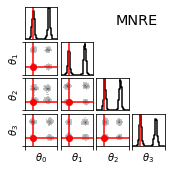

In [9]:
swy_s = gen_eggbox['swyft/nsims-10000']
dfs = swyft.utils.get_df_dict_from_weighted_marginals(swy_s)
# dfs = keyfilter(lambda x: x in [(0,), (1,), (0, 1)], dfs)
dfs = keyfilter(keep, dfs)

fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="MNRE",
    x=0.63,
    **fittext_kwargs,
)
fig.savefig("figures/eggbox-mnre-corner.png", **save_kwargs)

100%|██████████| 6/6 [00:00<00:00, 52.10it/s]


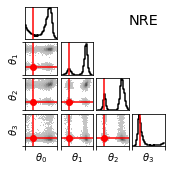

In [10]:
nre_s = gen_eggbox['sbi/nsims-10000']
marginals = tmnre.marginalize.all_marginals(nre_s)
dfs = swyft.utils.get_df_dict_from_marginals(marginals)
dfs = keyfilter(keep, dfs)

fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="NRE",
    x=0.7,
    **fittext_kwargs,
)
fig.savefig("figures/eggbox-nre-corner.png", **save_kwargs)

100%|██████████| 6/6 [00:00<00:00, 51.74it/s]


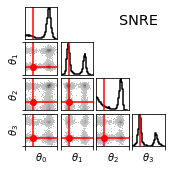

In [11]:
nre_s = gen_eggbox['seq/nsims-10000']
marginals = tmnre.marginalize.all_marginals(nre_s)
dfs = swyft.utils.get_df_dict_from_marginals(marginals)
dfs = keyfilter(keep, dfs)
fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="SNRE",
    x=0.65,
    **fittext_kwargs,
)
fig.savefig("figures/eggbox-snre-corner.png", **save_kwargs)

100%|██████████| 6/6 [00:00<00:00, 48.98it/s]


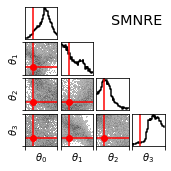

In [12]:
dfs = swyft.utils.get_df_dict_from_marginals(seq_eggbox)
dfs = keyfilter(keep, dfs)
fig, axes = cc.corner(
    dfs,
    **kwargs,
)
plt.figtext(
    s="SMNRE",
    x=0.6,
    **fittext_kwargs,
)
fig.savefig("figures/eggbox-msnre-corner.png", **save_kwargs)